# Automatic Speech Recognition

## 0  Outline
1. Setup & dependencies  
2. Download Free Spoken Digit Dataset (FSDD)  
3. Inspect audio & visualise MFCC / log‑Mel  
4. Prepare feature matrices  
5. **DTW baseline** (1‑NN with Dynamic Time Warping)  
6. **HMM** (per‑digit GMM‑HMM using `hmmlearn`)  
7. **CNN** classifier on log‑Mel spectrograms (PyTorch)  
8. Compare accuracies & confusion matrices  
9. Record your own digit and test  
10. Conclusions

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import subprocess
import pathlib
import zipfile
import urllib.request
import shutil
import sys
import json
import math
import random
import warnings
import librosa, librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from hmmlearn.hmm import GMMHMM
import joblib
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.utils.data as tud
import pandas as pd
import seaborn as sns
import sounddevice as sd
from scipy.io.wavfile import write
import time
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

c:\Users\zolta\Desktop\MATHOS\ASR-Project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.  Get the dataset

In [3]:
DATA_DIR = pathlib.Path('fsdd').resolve()

if not DATA_DIR.exists():
    print('Downloading FSDD...')
    !git clone --depth 1 https://github.com/Jakobovski/free-spoken-digit-dataset.git fsdd
else:
    print('FSDD already downloaded at', DATA_DIR)

FSDD already downloaded at C:\Users\zolta\Desktop\MATHOS\ASR-Project\fsdd


In [4]:
# Checking out one sample

sample_path = random.choice(glob.glob(str(DATA_DIR / 'recordings' / '*.wav')))
print('Sample file:', os.path.basename(sample_path))
audio, sr = librosa.load(sample_path, sr=8000)
ipd.Audio(audio, rate=sr)

Sample file: 5_george_43.wav


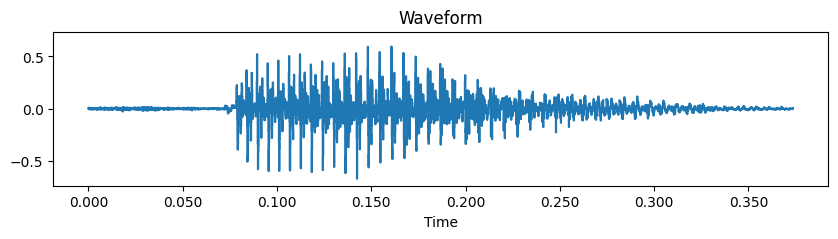

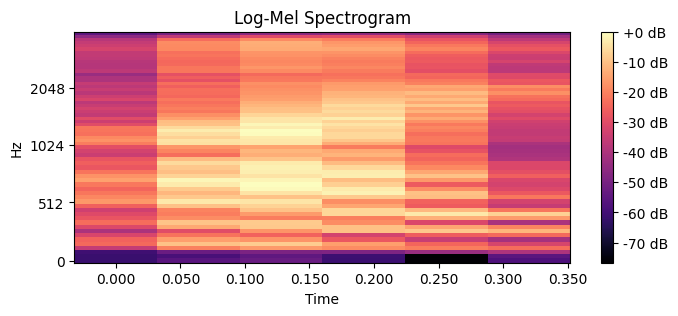

In [5]:
# Display waveform 
plt.figure(figsize=(10,2))
librosa.display.waveshow(audio, sr=sr)
plt.title('Waveform')
plt.show()

# Display the Log-Mel spectrogram
S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=64, fmax=4000)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(8,3))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram')
plt.show()

## 2.  Feature extraction

In [12]:
def extract_mfcc(path, sr=8000, n_mfcc=13):
    y, _ = librosa.load(path, sr=sr)
    mfcc_feat = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=256, n_fft=512)

    if mfcc_feat.shape[1] < 5:
        # Not enough frames for delta computation
        delta_feat = np.zeros_like(mfcc_feat)
    else:
        delta_feat = librosa.feature.delta(mfcc_feat, width=5)

    return np.vstack([mfcc_feat, delta_feat]).T  # shape (T, 26)

def extract_logmel(path, sr=8000, n_mels=64, max_frames=128):
    y, _ = librosa.load(path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=4000)
    logmel = librosa.power_to_db(mel, ref=np.max)
    # Pad / truncate to fixed length for CNN
    if logmel.shape[1] < max_frames:
        pad = np.full((n_mels, max_frames-logmel.shape[1]), logmel.min())
        logmel = np.hstack([logmel, pad])
    else:
        logmel = logmel[:, :max_frames]
    return logmel  # shape (64, max_frames)

In [13]:
# Build feature lists for all recordings
file_list = sorted(pathlib.Path(DATA_DIR/'recordings').glob('*.wav'))
labels = [int(f.name.split('_')[0]) for f in file_list]

mfcc_sequences = [extract_mfcc(str(p)) for p in file_list]
logmel_images  = [extract_logmel(str(p)) for p in file_list]

print('Total samples:', len(file_list))

Total samples: 3000


In [8]:
# Split the data into train/test sets
idx = list(range(len(file_list)))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42, stratify=labels)

print(f'Train: {len(train_idx)}, Test: {len(test_idx)}')

Train: 2400, Test: 600


## 3.  DTW 1‑NN baseline

DTW accuracy: 0.9783333333333334


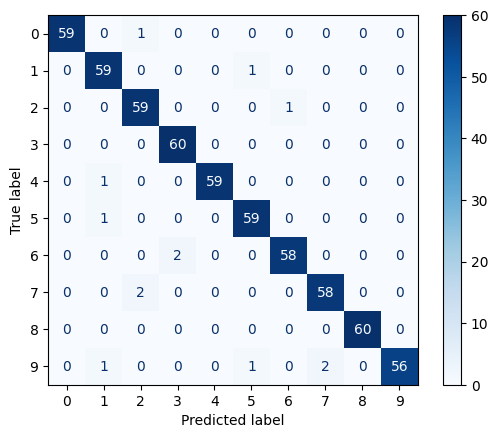

In [9]:
def dtw_distance(a,b):
    dist,_ = fastdtw(a,b, dist=euclidean)
    return dist

def predict_dtw(sample_idx, ref_idx):
    distances = [dtw_distance(mfcc_sequences[sample_idx], mfcc_sequences[r]) for r in ref_idx]
    best = ref_idx[int(np.argmin(distances))]
    return labels[best]

y_true = [labels[i] for i in test_idx]
y_pred = [predict_dtw(i, train_idx) for i in test_idx]

dtw_acc = accuracy_score(y_true, y_pred)
print('DTW accuracy:', dtw_acc)

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')

## 4.  GMM‑HMM per digit

In [14]:
frame_lengths = [mfcc.shape[0] for mfcc in mfcc_sequences]
print("Min length:", min(frame_lengths))
print("Max length:", max(frame_lengths))

Min length: 5
Max length: 72


HMM accuracy: 0.9916666666666667


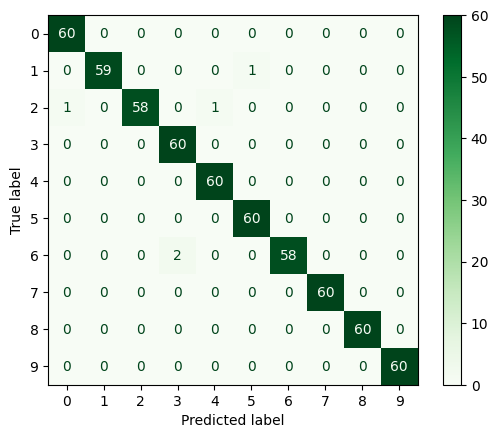

In [15]:
digit_models = {}
for d in range(10):
    seqs = [mfcc_sequences[i] for i in train_idx if labels[i]==d]
    lengths = [len(s) for s in seqs]
    X = np.vstack(seqs)
    model = GMMHMM(n_components=5, n_mix=4, covariance_type='diag', n_iter=100, verbose=False)
    model.fit(X, lengths)
    digit_models[d] = model

def predict_hmm(seq):
    scores = {d: m.score(seq) for d,m in digit_models.items()}
    return max(scores, key=scores.get)

y_pred_hmm = [predict_hmm(mfcc_sequences[i]) for i in test_idx]
hmm_acc = accuracy_score(y_true, y_pred_hmm)
print('HMM accuracy:', hmm_acc)

cm = confusion_matrix(y_true, y_pred_hmm)
ConfusionMatrixDisplay(cm).plot(cmap='Greens')

## 5.  CNN classifier

In [16]:
class CNNDigit(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64, num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        return self.classifier(x)

In [1]:
%pip uninstall torch torchvision torchaudio

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install torch==2.6.0+cu118 torchvision==0.17.0+cu118 torchaudio==2.6.0+cu118 --index-url https://download.pytorch.org/whl/cu118

In [19]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0))

CUDA available: False
Device count: 0


AssertionError: Torch not compiled with CUDA enabled

Using device: cpu


Epoch 1/8: 100%|██████████| 38/38 [00:06<00:00,  6.28it/s]


Loss 2.5287089347839355


Epoch 2/8: 100%|██████████| 38/38 [00:05<00:00,  6.34it/s]


Loss 2.348177671432495


Epoch 3/8: 100%|██████████| 38/38 [00:05<00:00,  6.41it/s]


Loss 2.325385093688965


Epoch 4/8: 100%|██████████| 38/38 [00:06<00:00,  6.31it/s]


Loss 2.4144601821899414


Epoch 5/8: 100%|██████████| 38/38 [00:06<00:00,  5.76it/s]


Loss 2.319841146469116


Epoch 6/8: 100%|██████████| 38/38 [00:07<00:00,  5.31it/s]


Loss 2.2456517219543457


Epoch 7/8: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Loss 2.3352890014648438


Epoch 8/8: 100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


Loss 2.3920321464538574
CNN accuracy: 0.11333333333333333


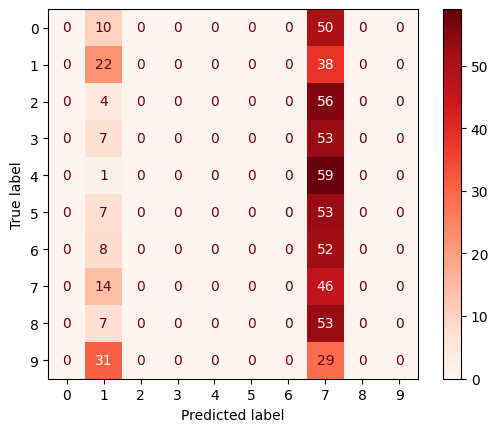

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

# Build tensors
X_images = torch.tensor(np.stack([img for img in logmel_images]), dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(labels, dtype=torch.long)

train_ds = tud.TensorDataset(X_images[train_idx], y_tensor[train_idx])
test_ds  = tud.TensorDataset(X_images[test_idx],  y_tensor[test_idx])
train_loader = tud.DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = tud.DataLoader(test_ds,  batch_size=64)

model = CNNDigit().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

EPOCHS = 30
for epoch in range(EPOCHS):
    model.train()
    for xb,yb in tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}'):
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        opt.step()
    print('Loss', loss.item())

# Evaluate
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb,yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu()
        all_preds.extend(preds.numpy())
        all_true.extend(yb.numpy())
cnn_acc = accuracy_score(all_true, all_preds)
print('CNN accuracy:', cnn_acc)

cm = confusion_matrix(all_true, all_preds)
ConfusionMatrixDisplay(cm).plot(cmap='Reds')

## 6.  Accuracy comparison

In [ ]:
acc = pd.Series({'DTW': dtw_acc, 'HMM': hmm_acc, 'CNN': cnn_acc})
print(acc)

plt.figure(figsize=(4,3))
sns.barplot(x=acc.index, y=acc.values)
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.title('Model comparison on FSDD')
plt.show()

## 7.  Record your own digit

In [ ]:
fs = 8000
seconds = 1
print('>> Speak a single digit (0-9) after the beep...')
time.sleep(0.5)
sd.play(0.5*np.sin(2*np.pi*440*np.linspace(0,0.2,int(0.2*fs))), fs)
sd.wait()
recording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()
fname = 'my_digit.wav'
write(fname, fs, recording)
print('Saved to', fname)
ipd.Audio(fname)

### Predict using each model

In [ ]:
seq = extract_mfcc('my_digit.wav')
img = extract_logmel('my_digit.wav')
img_t = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1,1,64,T)

print('DTW→', predict_dtw(len(mfcc_sequences), train_idx))   # rough
print('HMM→', predict_hmm(seq))
with torch.no_grad():
    p = model(img_t.to(device)).argmax(1).item()
print('CNN→', p)